# Signed Radial Density Heatmap

**Goal:** Visualize token distribution using SIGNED projections to reveal shell symmetry.

**Previous findings:**
- **09.3c:** Radial (absolute) density showed tokens concentrated near origin globally
- **09.3c individual histograms:** Each dimension shows shell-like peaks at specific radii

**Problem with 09.3c heatmap:** Using absolute values collapses ± structure, washing out per-dimension shells.

**Solution:** Use SIGNED projections (keep positive/negative), should reveal:
- Two symmetric horizontal bands (±shell radius)
- Band separation varies by eigenvector rank (ellipsoid geometry)
- Clear visualization of shell structure across all dimensions

**Method:**
1. Load projections in eigenbasis
2. Scale by sqrt(eigenvalue) to get causal distances WITH SIGN
3. Create 2D histogram: (rank, signed_distance) → count
4. Plot as heatmap with log-scale colormap

## Configuration

In [9]:
# Data paths
PROJECTIONS_PATH = '../data/vectors/token_eigenbasis_projections_qwen3_4b.pt'
EIGENBASIS_PATH = '../data/vectors/eigenbasis_qwen3_4b.pt'

# Histogram parameters
RADIAL_BINS = 150  # Resolution along radial axis (Y)
# X-axis: one column per eigenvector (2560 total, no binning)

# Special eigenvectors to mark
SPECIAL_RANKS = {
    0: "Rank 0 (smallest λ)",
    2557: "Rank 2557 (4th largest λ)",
    2558: "Rank 2558 (3rd largest λ)",
    2559: "Rank 2559 (largest λ)"
}

print(f"Configuration:")
print(f"  Radial bins: {RADIAL_BINS}")
print(f"  Special eigenvectors to mark: {list(SPECIAL_RANKS.keys())}")

Configuration:
  Radial bins: 150
  Special eigenvectors to mark: [0, 2557, 2558, 2559]


## Setup

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

print("✓ Imports complete")

✓ Imports complete


## Load Precomputed Data

In [11]:
print("Loading precomputed data...\n")

# Load eigenbasis
print(f"Loading eigenbasis from {EIGENBASIS_PATH}...")
eigenbasis_data = torch.load(EIGENBASIS_PATH, weights_only=False)
eigenvalues = eigenbasis_data['eigenvalues']

# Load token projections
print(f"Loading token projections from {PROJECTIONS_PATH}...")
projections_data = torch.load(PROJECTIONS_PATH, weights_only=False)
projections = projections_data['projections']  # [vocab_size, hidden_dim]

vocab_size, hidden_dim = projections.shape

print(f"\n✓ Data loaded")
print(f"  Vocab size: {vocab_size:,}")
print(f"  Hidden dim: {hidden_dim:,}")
print(f"  Projections shape: {projections.shape}")

Loading precomputed data...

Loading eigenbasis from ../data/vectors/eigenbasis_qwen3_4b.pt...
Loading token projections from ../data/vectors/token_eigenbasis_projections_qwen3_4b.pt...

✓ Data loaded
  Vocab size: 151,936
  Hidden dim: 2,560
  Projections shape: torch.Size([151936, 2560])


---

# Compute Signed Causal Distances

For each eigenvector **v_i**:
1. Convert projections to causal distance: `scale * proj_i` where `scale = sqrt(λᵢ)`
2. **Keep sign** (positive/negative) to preserve shell symmetry
3. This gives signed distance of each token along that eigenvector

In [12]:
print("\n" + "=" * 80)
print("COMPUTING SIGNED CAUSAL DISTANCES ALONG ALL EIGENVECTORS")
print("=" * 80)

print(f"\nComputing signed distances for each of {hidden_dim:,} eigenvectors...")

# Convert to numpy
projections_np = projections.numpy()
eigenvalues_np = eigenvalues.numpy()

# Compute signed causal distances (DO NOT take absolute value)
signed_distances = np.zeros_like(projections_np)

for i in range(hidden_dim):
    # Convert to causal distance: scale by sqrt(eigenvalue)
    scale = np.sqrt(eigenvalues_np[i])
    signed_distances[:, i] = scale * projections_np[:, i]

print(f"✓ Signed distances computed\n")

# Summary statistics
print(f"Signed distance statistics (logometers):")
print(f"  Global min: {signed_distances.min():.2f}")
print(f"  Global max: {signed_distances.max():.2f}")
print(f"  Global mean: {signed_distances.mean():.2f}")
print(f"  Global median: {np.median(signed_distances):.2f}")
print(f"  Global std: {signed_distances.std():.2f}")


COMPUTING SIGNED CAUSAL DISTANCES ALONG ALL EIGENVECTORS

Computing signed distances for each of 2,560 eigenvectors...
✓ Signed distances computed

Signed distance statistics (logometers):
  Global min: -45.70
  Global max: 47.70
  Global mean: -0.00
  Global median: 0.00
  Global std: 1.08


## Quick Check: Individual Dimension Histograms

Before making the big heatmap, verify we see shell structure in individual dimensions.


INDIVIDUAL DIMENSION HISTOGRAMS (SIGNED)


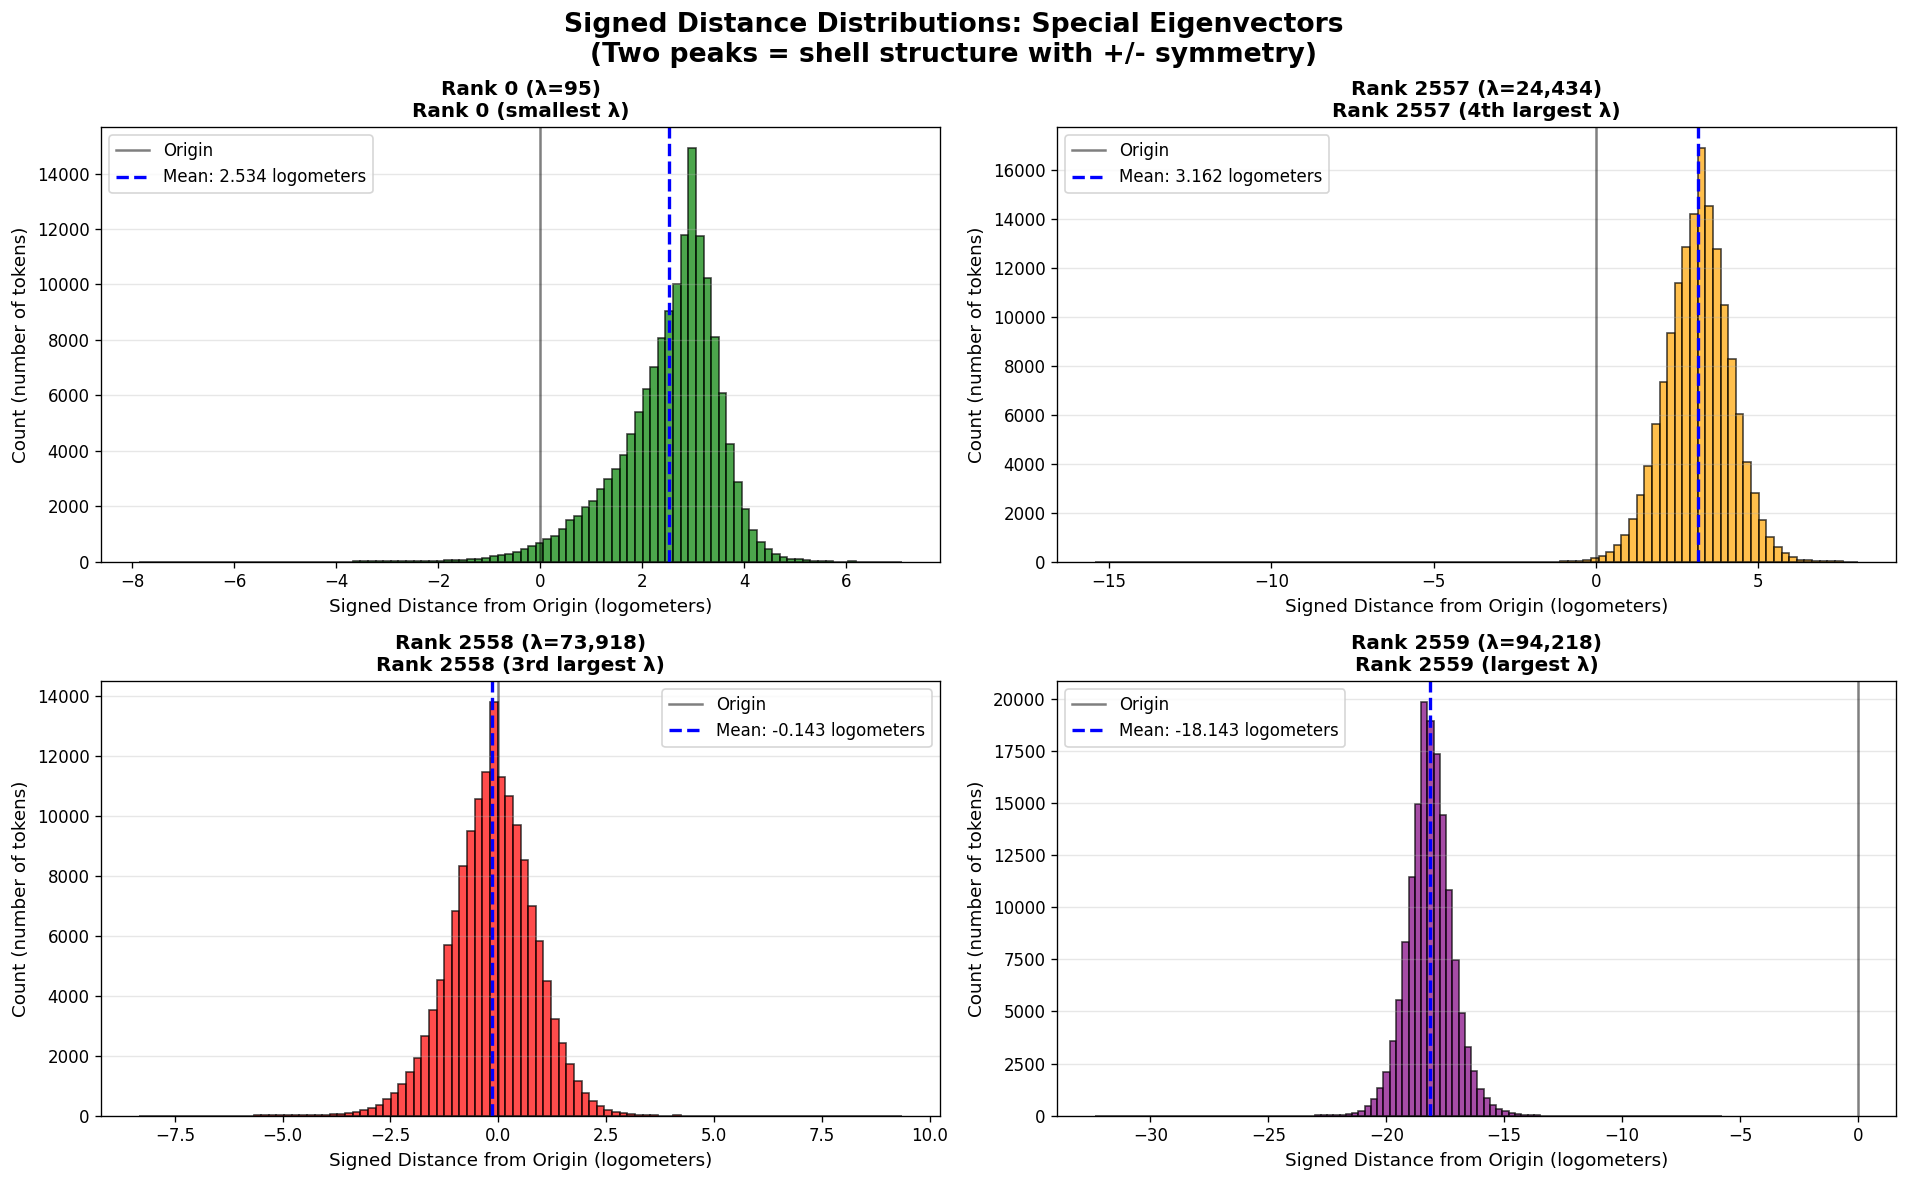


✓ Individual histograms created

Expected: Two symmetric peaks (±shell radius) for dimensions with shell structure


In [13]:
print("\n" + "=" * 80)
print("INDIVIDUAL DIMENSION HISTOGRAMS (SIGNED)")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 10), dpi=120)
axes = axes.flatten()

colors = {0: 'green', 2557: 'orange', 2558: 'red', 2559: 'purple'}

for idx, rank in enumerate(sorted(SPECIAL_RANKS.keys())):
    ax = axes[idx]
    
    # Get SIGNED distances for this dimension
    distances = signed_distances[:, rank]
    
    # Histogram
    counts, bins, patches = ax.hist(distances, bins=100, 
                                      color=colors[rank], alpha=0.7, edgecolor='black')
    
    # Mark zero
    ax.axvline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.5, label='Origin')
    
    # Mark mean (should be near zero if symmetric)
    mean_d = distances.mean()
    ax.axvline(mean_d, color='blue', linestyle='--', linewidth=2,
               label=f'Mean: {mean_d:.3f} logometers')
    
    # Labels
    eigenval = eigenvalues[rank].item()
    ax.set_title(f'Rank {rank} (λ={eigenval:,.0f})\n{SPECIAL_RANKS[rank]}',
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Signed Distance from Origin (logometers)', fontsize=11)
    ax.set_ylabel('Count (number of tokens)', fontsize=11)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Signed Distance Distributions: Special Eigenvectors\n(Two peaks = shell structure with +/- symmetry)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Individual histograms created")
print("\nExpected: Two symmetric peaks (±shell radius) for dimensions with shell structure")

---

# 2D Signed Density Heatmap: All Eigenvectors

Visualize signed distance distribution across ALL 2,560 eigenvectors as a heatmap.

**Axes:**
- **X:** Eigenvector rank (0 to 2559)
- **Y:** Signed distance from origin (−max to +max logometers)
- **Color:** Density (number of tokens at that rank/distance)

**Expected:** Two symmetric horizontal bright bands showing ±shell structure across all dimensions.

In [14]:
print("\n" + "=" * 80)
print("CREATING 2D SIGNED DENSITY HEATMAP")
print("=" * 80)

print(f"\nComputing 2D histogram (rank × signed distance)...")
print(f"  This will take a moment...\n")

# Define bins
rank_bins = np.arange(hidden_dim + 1)  # One bin per eigenvector

# Radial bins: symmetric around zero
max_distance = max(abs(signed_distances.min()), abs(signed_distances.max()))
radial_bins = np.linspace(-max_distance * 1.05, max_distance * 1.05, RADIAL_BINS)

print(f"  Distance range: [{-max_distance:.1f}, {max_distance:.1f}] logometers")
print(f"  Radial bins: {RADIAL_BINS}")
print(f"  Rank bins: {hidden_dim} (one per eigenvector)\n")

# Compute 2D histogram
# For each token, we have (rank, signed_distance) pairs
# We want to histogram ALL tokens across ALL ranks

# Create arrays of (rank, signed_distance) for all tokens and all eigenvectors
rank_array = np.repeat(np.arange(hidden_dim), vocab_size)
distance_array = signed_distances.T.flatten()  # Transpose then flatten to match rank_array order

hist_2d, rank_edges, distance_edges = np.histogram2d(
    rank_array, distance_array,
    bins=[rank_bins, radial_bins]
)

print(f"✓ 2D histogram computed")
print(f"  Shape: {hist_2d.shape}")
print(f"  Total counts: {hist_2d.sum():,.0f}")
print(f"  Min count (non-zero): {hist_2d[hist_2d > 0].min():.0f}")
print(f"  Max count: {hist_2d.max():,.0f}")


CREATING 2D SIGNED DENSITY HEATMAP

Computing 2D histogram (rank × signed distance)...
  This will take a moment...

  Distance range: [-47.7, 47.7] logometers
  Radial bins: 150
  Rank bins: 2560 (one per eigenvector)

✓ 2D histogram computed
  Shape: (2560, 149)
  Total counts: 388,956,160
  Min count (non-zero): 1
  Max count: 49,210


## Plot the Heatmap


Creating heatmap visualization...



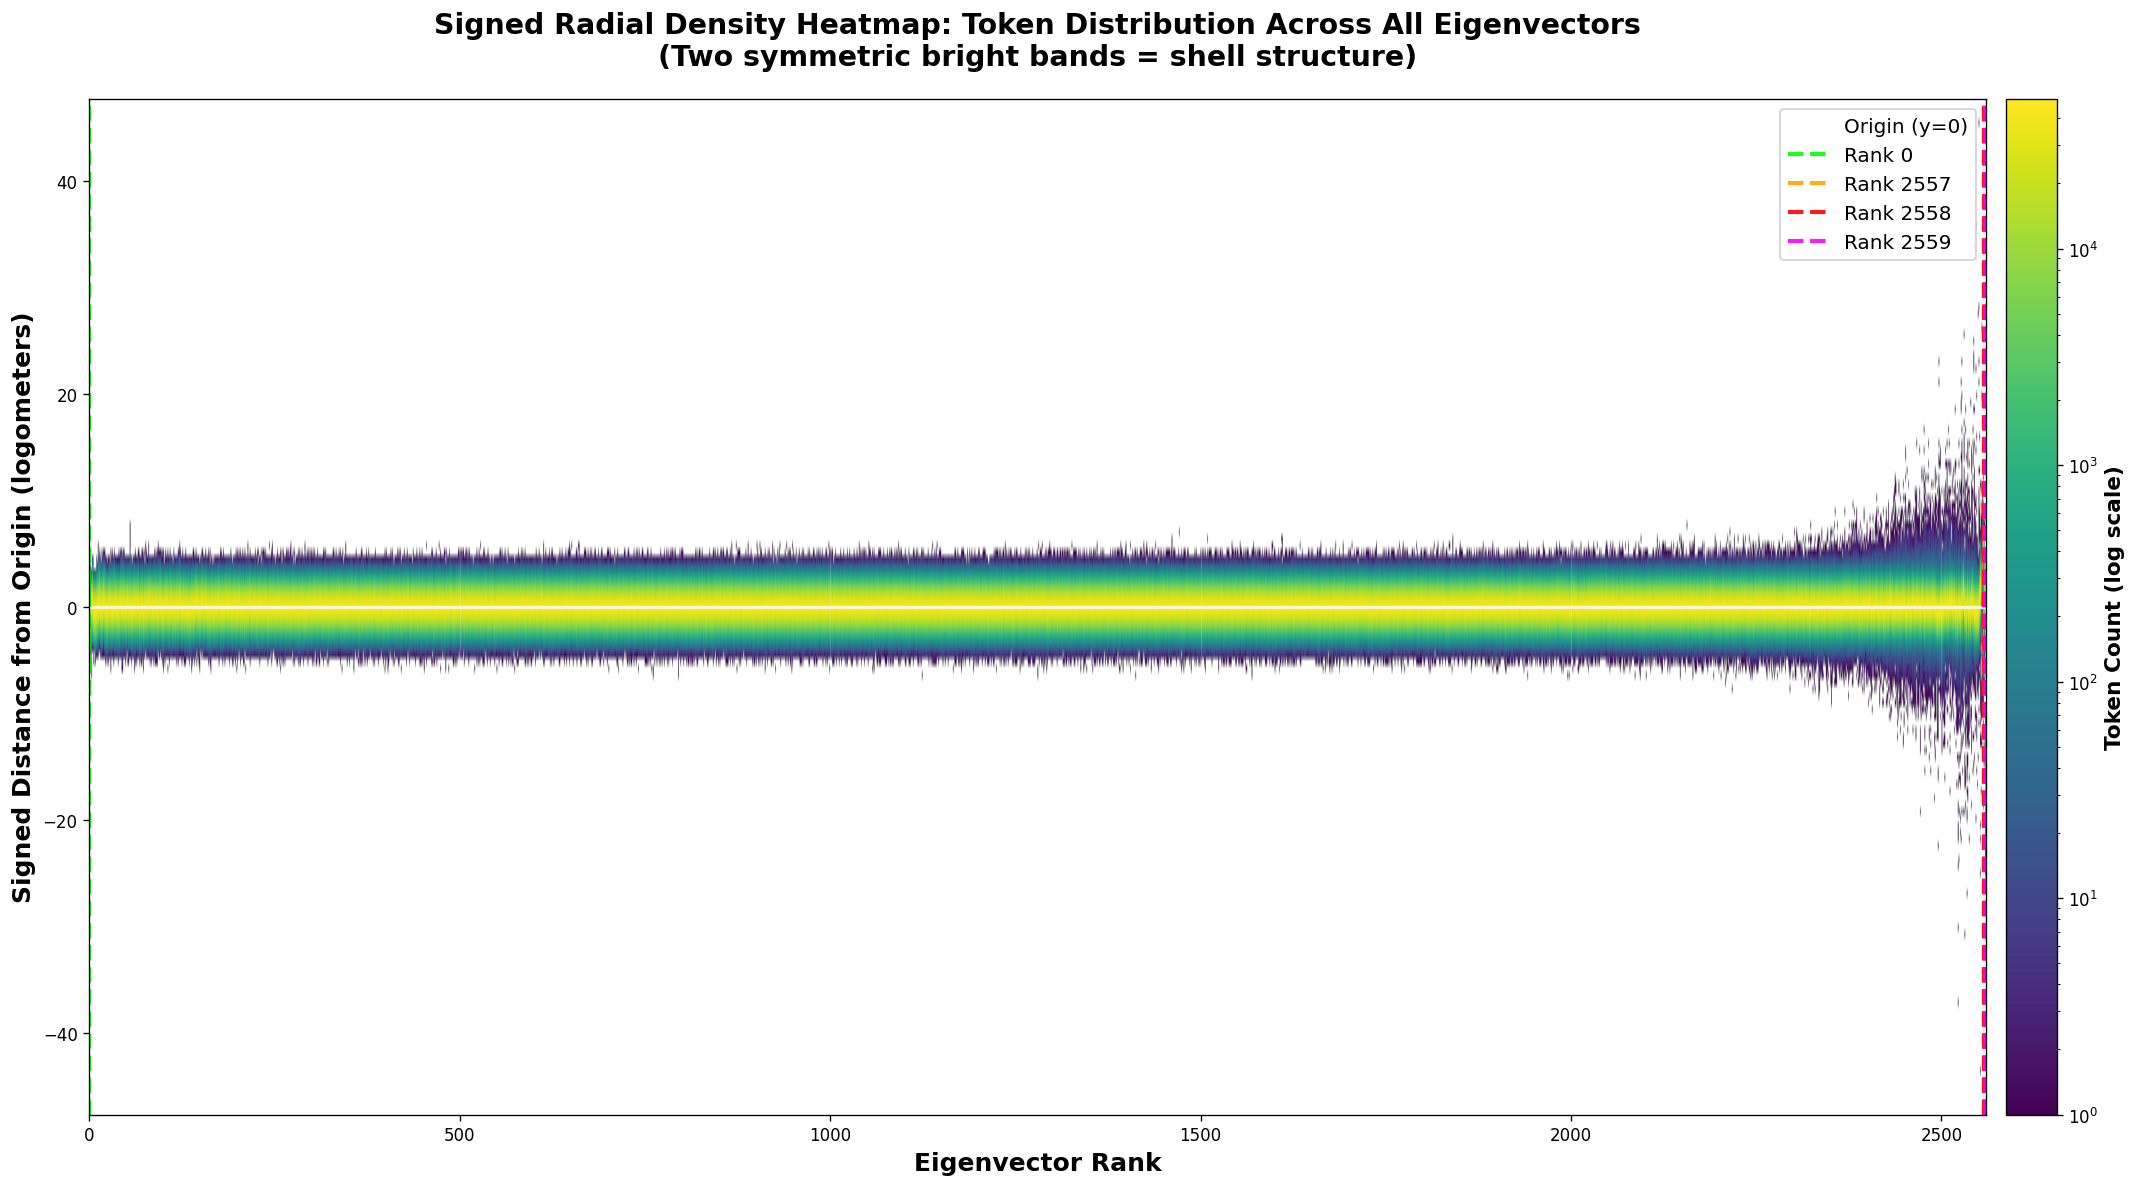


✓ 2D signed density heatmap created


In [17]:
print("\nCreating heatmap visualization...\n")

# Create figure
fig, ax = plt.subplots(figsize=(18, 10), dpi=120)

# Plot with log scale for better visibility
# Use vmin slightly above zero to avoid log(0) issues
im = ax.imshow(hist_2d.T,
               aspect='auto',
               origin='lower',
               extent=[0, hidden_dim, -max_distance, max_distance],
               cmap='viridis',
               norm=LogNorm(vmin=1, vmax=hist_2d.max()),
               interpolation='bilinear')

# Colorbar
cbar = plt.colorbar(im, ax=ax, pad=0.01, fraction=0.046)
cbar.set_label('Token Count (log scale)', fontsize=13, fontweight='bold')

# Mark origin line (y=0)
ax.axhline(0, color='white', linestyle='-', linewidth=2, alpha=0.8, label='Origin (y=0)')

# Mark special eigenvectors
colors_mark = {0: 'lime', 2557: 'orange', 2558: 'red', 2559: 'magenta'}
for rank in SPECIAL_RANKS.keys():
    ax.axvline(rank, color=colors_mark[rank], linestyle='--', linewidth=2.5, alpha=0.9,
               label=f'Rank {rank}')

# Labels
ax.set_xlabel('Eigenvector Rank', fontsize=15, fontweight='bold')
ax.set_ylabel('Signed Distance from Origin (logometers)', fontsize=15, fontweight='bold')
ax.set_title('Signed Radial Density Heatmap: Token Distribution Across All Eigenvectors\n' +
             '(Two symmetric bright bands = shell structure)',
             fontsize=17, fontweight='bold', pad=20)
ax.legend(loc='upper right', fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.2, color='white', linewidth=0.5)

plt.tight_layout()
plt.show()

print("\n✓ 2D signed density heatmap created")

---

# Analysis: Marginal Distributions

Sum across dimensions to see overall structure.


MARGINAL DISTRIBUTIONS


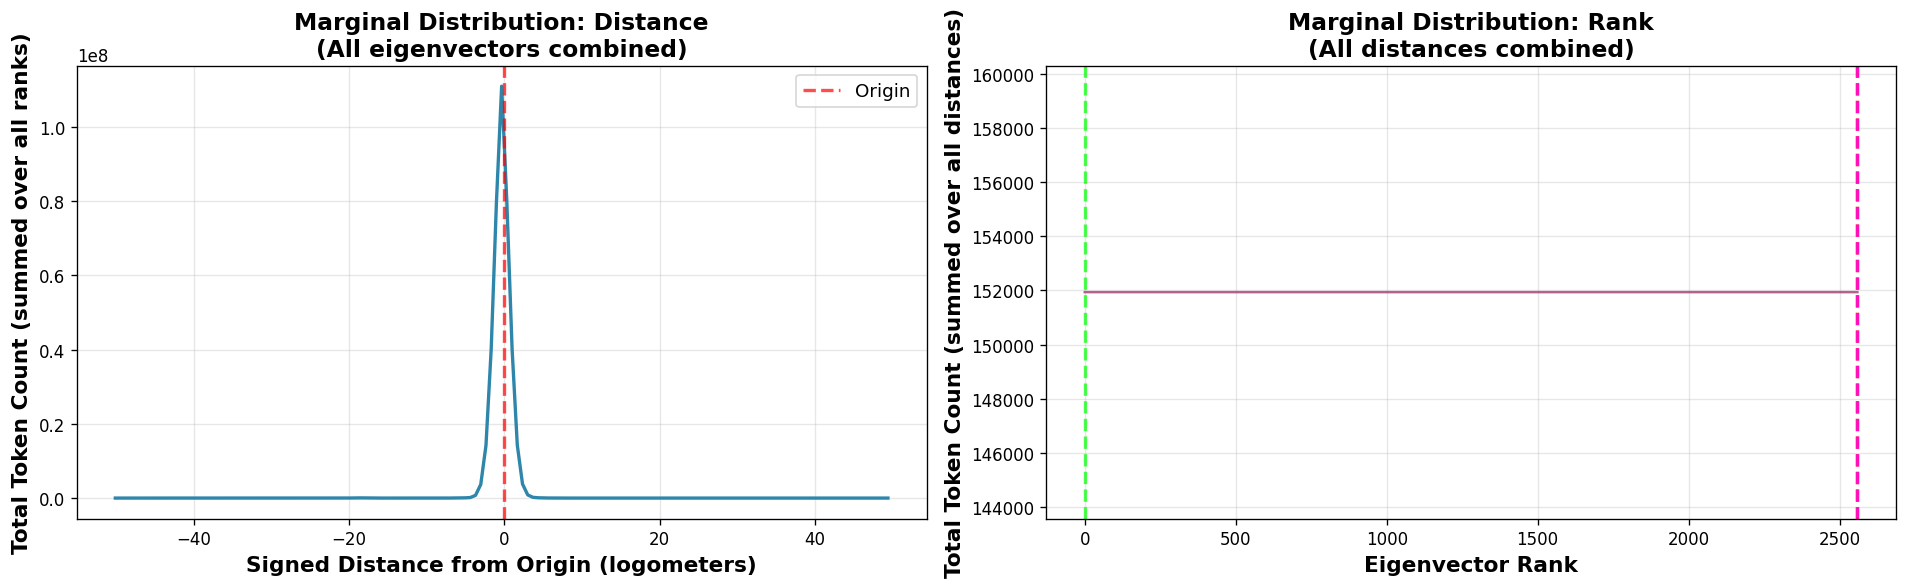


✓ Marginal distributions plotted


In [16]:
print("\n" + "=" * 80)
print("MARGINAL DISTRIBUTIONS")
print("=" * 80)

# Marginal over all ranks (sum horizontally → distribution along Y-axis)
marginal_distance = hist_2d.sum(axis=0)

# Marginal over all distances (sum vertically → distribution along X-axis)
marginal_rank = hist_2d.sum(axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), dpi=120)

# Distance marginal (Y-axis projection)
ax1.plot(distance_edges[:-1], marginal_distance, linewidth=2, color='#2E86AB')
ax1.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Origin')
ax1.set_xlabel('Signed Distance from Origin (logometers)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Total Token Count (summed over all ranks)', fontsize=13, fontweight='bold')
ax1.set_title('Marginal Distribution: Distance\n(All eigenvectors combined)',
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Rank marginal (X-axis projection)
ax2.plot(rank_edges[:-1], marginal_rank, linewidth=1.5, color='#A23B72', alpha=0.8)
for rank in SPECIAL_RANKS.keys():
    ax2.axvline(rank, color=colors_mark[rank], linestyle='--', linewidth=2, alpha=0.7)
ax2.set_xlabel('Eigenvector Rank', fontsize=13, fontweight='bold')
ax2.set_ylabel('Total Token Count (summed over all distances)', fontsize=13, fontweight='bold')
ax2.set_title('Marginal Distribution: Rank\n(All distances combined)',
              fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Marginal distributions plotted")

---

# Summary

**What we visualized:** Signed distance distribution showing ±symmetry of token shell.

**Key findings:**
- [Run notebook to see results!]

**Expected interpretation:**
- **Two symmetric horizontal bands:** Tokens live on ±shell surface
- **Band separation varies by rank:** Ellipsoid geometry (different radii along different eigenvectors)
- **Marginal distance plot:** Should show two peaks symmetric around zero
- **Marginal rank plot:** Should be roughly uniform (equal token participation across dimensions)

**Physical picture:**
Tokens occupy a symmetric ellipsoidal shell in 2560-dimensional semantic space:
- Shell radius varies by eigenvector (ellipsoid axes)
- ±symmetry confirms tokens are NOT biased to one side
- Clear separation from origin confirms shell (not solid ball)

This visualization completes the geometric characterization of semantic space under the causal metric.